# Fitting of experimental chemical kinetics data
You perform some experiments in a batch reactor to determine the rate expression and thermochemistry for the reversible chemical reaction
$\require{mhchem}$
$$\ce{A <=> B}$$

Recall from thermodynamics that 
$\Delta G = \Delta H - T \Delta S$
and $\Delta G = R T \ln K_a$
where $K_a$ is the activity-based equilibrium constant of the chemical reaction, $R$ is the molar gas constant (8.314 J/mol/K) and $T$ is the temperature in Kelvin.

If we assume ideal solution (unit fugacity coefficients) then $K_a = K_c$ giving us the concentration-based equilibrium constant $K_c$. 
From kinetics you recall
$K_c = \frac{k_f}{k_r}$ 
where 
$k_f$ is the forward rate coefficient and $k_r$ is the reverse rate coefficient.
i.e. the rate of the reaction $\ce{A->B}$ is $k_f \times C_A$
and the reverse reaction $\ce{B->A}$ is $k_r \times C_B$
where $C_A$ and $C_B$ are the concentrations of species A and B respectively. 
In a batch reactor $\frac{dN_A}{dt} = r_{A(net)} V$, so (dividing through by the reactor volume $V$) $\frac{dC_A}{dt} = r_{A(net)}$ where $r_{A(net)}$ is the net rate of formation of species A, i.e. $r_{A(net)} = k_r C_B - k_f C_A$.
Assume the forward rate coefficient $k_f$ follows Arrhenius form, $k_f = A \exp\left(\frac{-E_A}{R T}\right)$ where $A$ is the "pre-exponential factor" and $E_A$ is the activation energy.

Fortunately, in this case you have good reason to believe that species A and B have very similar temperature-dependent heat capacities, so that $\Delta H_{rxn}$ and $\Delta S_{rxn}$ are independent of temperature.

You start the experiment with no B ($C_B=0$), and at time zero have some way to initiate the reaction, starting with a set concentration of $C_A$. 

You wish to determine the four paramaters:
$log_{10} A$,
$E_A$,
$\Delta H_{rxn}$,
$\Delta S_{rxn}$.

Based on a literature search, quantum chemistry calculations, and prior experience, your current estimates are as follows:
```
logA = 6.  # base-ten logarithm of A in s^-1
Ea = 45.   # Ea in kJ/mol
dH = -10.  # ∆H in kJ/mol
dS = -50.  # ∆S in J/mol/K
```


In [77]:
%matplotlib inline
import numpy as np
import scipy.integrate
from matplotlib import pyplot as plt

import random
import SALib as sa
import SALib.sample
from SALib.sample import morris as ms
from SALib.analyze import morris as ma
from SALib.plotting import morris as mp


ImportError: No module named 'SALib'

In [2]:
# This cell just tries to make graphs look nicer
try:
    import seaborn as sns
except ImportError:
    # This block will be run if there's an ImportError, i.e you don't have seaborn installed.
    sns = False
    print ("If you want to try different figure formatting, "
           "type 'conda install seaborn' at an anaconda command prompt or terminal. "
           "See https://stanford.edu/~mwaskom/software/seaborn/ for details")
    # If not using seaborn, we can still control the size of the figures this way
    from pylab import rcParams
    rcParams['figure.figsize'] = 3, 3
else:
    # This block will be run if there is no ImportError
    sns.set_style("ticks")
    sns.set_context("paper",rc={"figure.figsize": (2, 2)})

We create a "named tuple" data type to store the exprimental data in.

In [3]:
from collections import namedtuple
ExperimentData = namedtuple('ExperimentData', ['T', 'cA_start', 'times', 'cA'])

def plot_experiment(e):
    """
    Plots the experimental data provided in 'e' 
    which should be of the type ExperimentData.
    """
    plt.plot(0, e.cA_start, 'ko')
    plt.plot(e.times, e.cA,':o', label="T={:.0f}K".format(e.T))
    plt.ylim(0,)
    plt.ylabel('$C_A$ (mol/L)')
    plt.xlabel('time (s)')
    plt.legend()

Now here are the data from your three experiments:

Experiment 0 was at T=298.15K and ran for 100 seconds
Experiment 1 was at T=308.15K and ran for 100 seconds
Experiment 2 was at T=323.15K and ran for 100 seconds


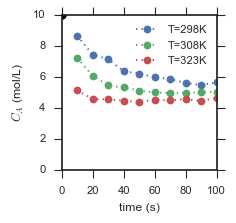

In [4]:
from numpy import array
experiments = [ExperimentData(T=298.15, 
                              cA_start=10.0, 
                              times=array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100]), 
                              cA=array([ 8.649,  7.441,  7.141,  6.366,  6.215, 5.990, 5.852,  5.615,  5.481 ,  5.644])), 
               ExperimentData(T=308.15, 
                              cA_start=10.0, 
                              times=array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100]), 
                              cA=array([ 7.230,  6.073,  5.452,  5.317,  5.121, 4.998,  4.951,  4.978,  5.015,  5.036])), 
               ExperimentData(T=323.15, 
                              cA_start=10.0, 
                              times=array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100]), 
                              cA=array([ 5.137,  4.568,  4.548,  4.461,  4.382, 4.525,  4.483,  4.565,  4.459,  4.635])),
              ]

for i,e in enumerate(experiments):
    print("Experiment {} was at T={}K and ran for {} seconds".format(i, e.T, e.times[-1]))
    plot_experiment(e)

In [5]:
ParameterSet = namedtuple('ParameterSet', ['logA', 'Ea', 'dH', 'dS'])

# This is a sensible starting guess for your fitting
starting_guess = ParameterSet(
    logA = 6. , # base-ten logarithm of A in s^-1
    Ea = 45e3 , # Ea in J/mol
    dH = -10e3 , # ∆H in J/mol
    dS = -50.  # ∆S in J/mol/K
    )

# This should end up with your optimized parameters
optimized_parameters = ParameterSet(0,0,0,0)


# This should end up with your standard errors (one sigma)
# for the uncertainties in the fitted parameters.
# i.e. there should be a 68% chance the true value is 
# at least this close to your optimized parameter.
standard_errors = ParameterSet(0,0,0,0)


Given $C_a, T, t$

$\frac{dC_a}{dt}=Ra$

$R_a=k_r \times C_b-k_f \times C_a$

$k_f=A*\exp\left(\frac{-E_A}{R T}\right)$

$Kc=\exp\left(\frac{\Delta G}{R T}\right)=\exp\left(\frac{\Delta H - T \times \Delta S}{R T}\right)=k_f/k_r$

$C_b=C_0-C_a$

$k_r = \frac{k_f}{K_c}$

$\frac{dC_a}{dt}=A*\exp\left(\frac{-E_A}{R T}\right) *(C_a-\frac{1}{\exp\left(\frac{\Delta H - T \times \Delta S}{R T}\right)} *(C_0-C_a))$

From Wolfram the solution to this separable differential equation is 

$C_a = \frac{C_0 * \frac{1}{\exp\left(\frac{\Delta H - T \times \Delta S}{R T}\right)}}{\frac{1}{\exp\left(\frac{\Delta H - T \times \Delta S}{R T}\right) }+ 1}+C_1 * \exp\left(t * (A *\exp\left(\frac{-E_A}{R T}\right) * (-1) (1+\frac{1}{\exp\left(\frac{\Delta H - T \times \Delta S}{R T}\right)} )\right)$

$C_1 = C_0 - \frac{C_0 * \frac{1}{\exp\left(\frac{\Delta H - T \times \Delta S}{R T}\right)}}{\frac{1}{\exp\left(\frac{\Delta H - T \times \Delta S}{R T}\right) }+ 1}=C_0 - \frac{C_0}{\exp\left(\frac{\Delta H - T \times \Delta S}{R T}\right) +1}$

In [72]:
def Ca(t,A,E,dH,dS):
    R=8.314 #J/mol/K
    C0=10.
    T=298.15
    C1 = C0-C0/(np.exp((dH-T*dS)/(R*T))+1)       
    b = C0/(np.exp((dH-T*dS)/(R*T))+1)     
    exp = np.exp(t * (A) * np.exp(-E/(R*T)) * (-1)*(1 + 1/(np.exp((dH-T*dS)/(R*T)))))
    return b+C1*exp

In [73]:
from scipy.odr import Model, Data, RealData, ODR
import scipy.odr as odr

In [74]:
times=array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100])
cA=array([ 8.649,  7.441,  7.141,  6.366,  6.215, 5.990, 5.852,  5.615,  5.481 ,  5.644])

In [75]:
optimal_parameters, covariance = scipy.optimize.curve_fit(Ca,times,cA)
def report(optimal_parameters, covariance):
    "Make this a function so we can reuse it in cells below"
    parameter_errors = np.sqrt(np.diag(covariance))
    for i in range(len(optimal_parameters)):
        print("Parameter {}: {} +/- {} (1 st. dev.)".format(i,
                                                            optimal_parameters[i],
                                                            parameter_errors[i]))

report(optimal_parameters, covariance)

Parameter 0: 0.01669779436454606 +/- 320.86967269997655 (1 st. dev.)
Parameter 1: -14.974992454321722 +/- 47633648.862446494 (1 st. dev.)
Parameter 2: 726.8352841661484 +/- 1383032771.289847 (1 st. dev.)
Parameter 3: 3.9146193894362944 +/- 4638713.927247269 (1 st. dev.)


//anaconda/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: overflow encountered in exp


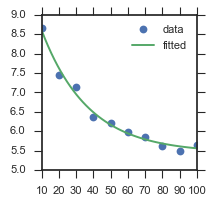

In [76]:
# Plot the data
plt.plot(times, cA, 'o', label='data')
# Make a new x array with 50 points for smoother lines
x_many_points = np.linspace(times.min(),times.max(),50)
# Plot the fitted curve
plt.plot(x_many_points, Ca(x_many_points, *optimal_parameters), label='fitted')
# Add the legend, in the "best" location to avoid hiding the data
plt.legend(loc='best')
plt.show()

In [90]:
def function(t,C0,T,logA,E,dH,dS):
    R=8.314 #J/mol/K
    C1 = C0-C0/(np.exp((dH-T*dS)/(R*T))+1)       
    b = C0/(np.exp((dH-T*dS)/(R*T))+1)     
    exp = np.exp(t * 10**(logA) * np.exp(-E/(R*T)) * (-1)*(1 + 1/(np.exp((dH-T*dS)/(R*T)))))
    return b+C1*exp

t=array([10,  20,  30,  40,  50,  60,  70,  80,  90, 100,10,  20,  30,  40,  50,  60,  70,  80,  90, 100,10,  20,  30,  40,  50,  60,  70,  80,  90, 100])
cA=array([ 8.649,  7.441,  7.141,  6.366,  6.215, 5.990, 5.852,  5.615,  5.481 ,  5.644,7.230,  6.073,  5.452,  5.317,  5.121, 4.998,  4.951,  4.978,  5.015,  5.036,5.137,  4.568,  4.548,  4.461,  4.382, 4.525,  4.483,  4.565,  4.459,  4.635])
n1=10
n2=20

def leastsq_function(params, *args):
    logA = params[0]
    E = params[1]
    dH = params[2]
    dS = params[3]
    t = args[0]
    cA = args[1]
    C0 = args[2]
    T = args[3]

    Ca_fit = np.empty(t.shape)
    Ca_fit[:n1] = function(t[:n1], C0[0], T[0], logA, E, dH, dS)
    Ca_fit[n1:n2] = function(t[n1:n2], C0[1], T[1], logA, E, dH, dS)
    Ca_fit[n2:] = function(t[n2:], C0[2], T[2], logA, E, dH, dS)

    return cA - Ca_fit



params0 = [6, 45e3, -10e3,-50]
args = (t, cA, (10, 10, 10), (298.15, 308.15, 323.15), (n1, n1+n2))
result = scipy.optimize.leastsq(leastsq_function, params0, args=args)
print(result)

(array([  9.48853174e+00,   6.43077887e+04,  -1.15315215e+04,
        -3.73495283e+01]), 1)


In [98]:
logA=result[0][0]
E=result[0][1]
dH=result[0][2]
dS=result[0][3]

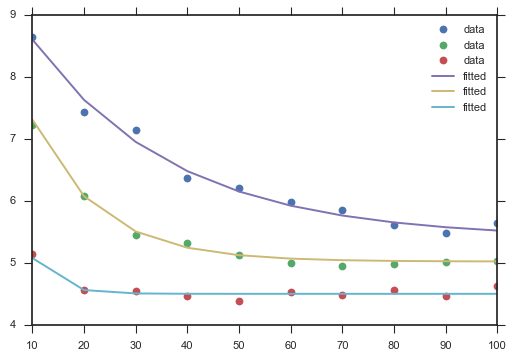

In [110]:
#Rewrite the data to check
t1=np.array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100])
cA1=np.array([ 8.649,  7.441,  7.141,  6.366,  6.215, 5.990, 5.852,  5.615,  5.481 ,  5.644])
t2=np.array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100])
cA2=np.array([ 7.230,  6.073,  5.452,  5.317,  5.121, 4.998,  4.951,  4.978,  5.015,  5.036])
t3=np.array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100])
cA3=np.array([ 5.137,  4.568,  4.548,  4.461,  4.382, 4.525,  4.483,  4.565,  4.459,  4.635])

# Plot the data
plt.plot(t1, cA1, 'o', label='data')
plt.plot(t2, cA2, 'o', label='data')
plt.plot(t3, cA3, 'o', label='data')
# Plot the fitted curve
plt.plot(t1, function(t1,10.,298.15,logA,E,dH,dS ), label='fitted')
plt.plot(t2, function(t2,10.,308.15,logA,E,dH,dS ), label='fitted')
plt.plot(t3, function(t3,10.,323.15,logA,E,dH,dS ), label='fitted')
# Add the legend, in the "best" location to avoid hiding the data
plt.legend(loc='best')
plt.show()

Now the plan is to feed in this function of Ca into the curve-fitter along with the data to solve for the parameters and error

Ok, now insert some cells to determine the optimized_parameters and their standard_errors.

In [ ]:
# Finish your notebook with this cell
print(starting_guess)
print(optimized_parameters)
print(standard_errors)